In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder \
    .appName("NYC_Taxi_EDA") \
    .config("spark.sql.adaptive.enabled","true") \
    .getOrCreate()
    
df_bronze = spark.read.parquet("../data/dataset.parquet")

#### Supprimer les lignes avec valeurs NULL critiques

In [51]:
critical_columns = [
    "passenger_count", 
    "RatecodeID", 
    "store_and_fwd_flag",
    "congestion_surcharge",
    "Airport_fee"
]

rows_before = df_bronze.count()
df_silver = df_bronze.dropna(subset=critical_columns)
rows_after = df_silver.count()
print(f"Lignes supprimées (NULL critiques): {rows_before - rows_after:,}")

Lignes supprimées (NULL critiques): 540,149


In [52]:
total_rows = df_silver.count()
print("POURCENTAGE DE VALEURS MANQUANTES:")
for col_name in df_silver.columns:
    missing_count = df_silver.filter(col(col_name).isNull()).count()
    percentage = (missing_count / total_rows) * 100
    if percentage > 0:
        print(f"{col_name}: {percentage:.2f}%")

POURCENTAGE DE VALEURS MANQUANTES:


##### SUPPRESSION DES VALEURS ABERRANTES

In [53]:
rows_before = df_bronze.count()

df_silver = df_silver.filter(
    (col("trip_distance") >= 0.1) & (col("trip_distance") <= 50) &
    
    # Montants positifs
    (col("fare_amount") >= 2.5) & (col("fare_amount") < 200) &
    (col("total_amount") >= 3) & (col("total_amount") < 250) &
    
    
    (col("tip_amount") <= 100) &
    
    # Tolls: max $50
    (col("tolls_amount") <= 50) &
    
    # Nombre de passagers raisonnable
    (col("passenger_count") > 0) & (col("passenger_count") <= 6) &
    
    # Durée du trajet cohérente
    (unix_timestamp(col("tpep_dropoff_datetime")) > 
     unix_timestamp(col("tpep_pickup_datetime")))
)

rows_after = df_silver.count()
print(f"✓ Lignes supprimées (aberrantes): {rows_before - rows_after:,}")
print(f"✓ Lignes conservées: {rows_after:,} ({(rows_after/rows_before)*100:.2f}%)")

✓ Lignes supprimées (aberrantes): 668,408
✓ Lignes conservées: 2,806,818 (80.77%)


#### STANDARDISATION DES TYPES

#### convertir les colonnes categorielle en types appropries

In [54]:
df_silver = df_silver \
    .withColumn("VendorID", col("VendorID").cast(IntegerType())) \
    .withColumn("RatecodeID", col("RatecodeID").cast(IntegerType())) \
    .withColumn("payment_type", col("payment_type").cast(IntegerType())) \
    .withColumn("passenger_count", col("passenger_count").cast(IntegerType()))

#### valider les valeurs catégorielles

In [55]:
df_silver = df_silver.filter(
    col("VendorID").isin([1, 2]) &
    col("RatecodeID").isin([1, 2, 3, 4, 5, 6]) &
    col("payment_type").isin([0, 1, 2, 3, 4, 5]) &
    col("store_and_fwd_flag").isin(['Y', 'N'])
)

#### CREATION DE LA CIBLE

In [56]:
df_silver = df_silver.withColumn('trip_duration',
                   (unix_timestamp('tpep_dropoff_datetime')-unix_timestamp('tpep_pickup_datetime'))/60)

##### DISTRIBUTION DE LA CIBLE (trip_duration)

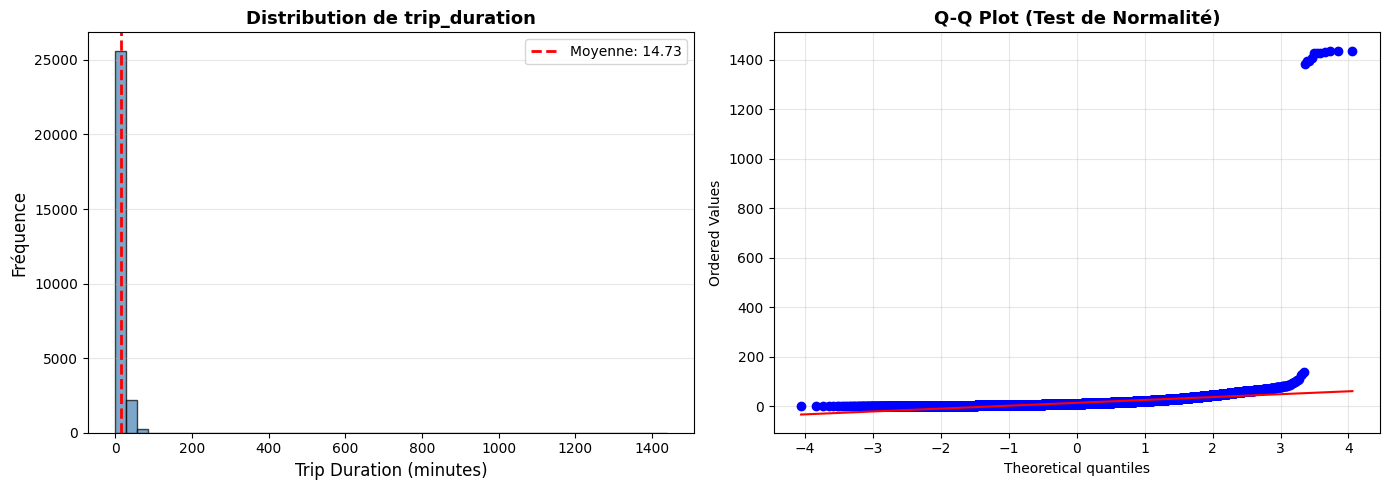

In [57]:
duration_sample = df_silver.select("trip_duration").sample(False, 0.01, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(duration_sample['trip_duration'], bins=50, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de trip_duration', fontsize=13, fontweight='bold')
axes[0].axvline(duration_sample['trip_duration'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Moyenne: {duration_sample["trip_duration"].mean():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

from scipy import stats
stats.probplot(duration_sample['trip_duration'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test de Normalité)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
df_silver.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+------------------+--------------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|cbd_congestion_fee|       trip_duration|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+-----------

In [59]:
stats = df_silver.select("improvement_surcharge").describe()
print("\n📈 Statistiques de base:")
stats.show()


📈 Statistiques de base:


+-------+---------------------+
|summary|improvement_surcharge|
+-------+---------------------+
|  count|              2767823|
|   mean|   0.9999963870522067|
| stddev| 0.001900772486440...|
|    min|                  0.0|
|    max|                  1.0|
+-------+---------------------+



#### DÉTECTION DES OUTLIERS - TRIP DURATION

In [60]:
stats = df_silver.select("trip_duration").describe()
print("\n📈 Statistiques de base:")
stats.show()


📈 Statistiques de base:


+-------+--------------------+
|summary|       trip_duration|
+-------+--------------------+
|  count|             2767823|
|   mean|  14.684613846333372|
| stddev|   28.50972624960572|
|    min|0.016666666666666666|
|    max|   5626.316666666667|
+-------+--------------------+



In [61]:
advanced_stats = df_silver.select(
    count("trip_duration").alias("count"),
    min("trip_duration").alias("min"),
    max("trip_duration").alias("max"),
    avg("trip_duration").alias("mean"),
    stddev("trip_duration").alias("std_dev"),
    variance("trip_duration").alias("variance"),
    skewness("trip_duration").alias("skewness"),
    kurtosis("trip_duration").alias("kurtosis")
).collect()[0]

In [62]:
print(f"""
📊 STATISTIQUES AVANCÉES:
   • Nombre de trajets: {advanced_stats['count']:,}
   • Minimum: {advanced_stats['min']:.2f} minutes
   • Maximum: {advanced_stats['max']:.2f} minutes ({advanced_stats['max']/60:.2f} heures)
   • Moyenne: {advanced_stats['mean']:.2f} minutes
   • Écart-type: {advanced_stats['std_dev']:.2f} minutes
   • Variance: {advanced_stats['variance']:.2f}
   • Skewness: {advanced_stats['skewness']:.2f} (asymétrie)
   • Kurtosis: {advanced_stats['kurtosis']:.2f} (aplatissement)
""")


📊 STATISTIQUES AVANCÉES:
   • Nombre de trajets: 2,767,823
   • Minimum: 0.02 minutes
   • Maximum: 5626.32 minutes (93.77 heures)
   • Moyenne: 14.68 minutes
   • Écart-type: 28.51 minutes
   • Variance: 812.80
   • Skewness: 43.81 (asymétrie)
   • Kurtosis: 2581.09 (aplatissement)



In [63]:
if advanced_stats['skewness'] > 1:
    print("⚠️  ALERTE: Distribution fortement asymétrique à droite (présence d'outliers)")
elif advanced_stats['skewness'] > 0.5:
    print("⚠️  Distribution modérément asymétrique à droite")
else:
    print("✅ Distribution relativement symétrique")

⚠️  ALERTE: Distribution fortement asymétrique à droite (présence d'outliers)


#### DÉTECTION PAR IQR (Interquartile Range)

In [64]:
quantiles = df_silver.stat.approxQuantile("trip_duration", [0.25, 0.50, 0.75], 0.01)
Q1 = quantiles[0]
Q2 = quantiles[1]  # Médiane
Q3 = quantiles[2]
IQR = Q3 - Q1

# Calculer les limites (règle standard: 1.5 * IQR)
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Limites extrêmes (règle: 3 * IQR)
extreme_lower = Q1 - 3 * IQR
extreme_upper = Q3 + 3 * IQR

print(f"""
📊 QUARTILES ET IQR:
   • Q1 (25%): {Q1:.2f} minutes
   • Q2 (50%, Médiane): {Q2:.2f} minutes
   • Q3 (75%): {Q3:.2f} minutes
   • IQR (Q3 - Q1): {IQR:.2f} minutes

🎯 LIMITES DE DÉTECTION (1.5 × IQR):
   • Limite inférieure: {lower_bound_iqr:.2f} minutes
   • Limite supérieure: {upper_bound_iqr:.2f} minutes

🔴 LIMITES EXTRÊMES (3 × IQR):
   • Limite inférieure extrême: {extreme_lower:.2f} minutes
   • Limite supérieure extrême: {extreme_upper:.2f} minutes
""")


📊 QUARTILES ET IQR:
   • Q1 (25%): 7.07 minutes
   • Q2 (50%, Médiane): 11.18 minutes
   • Q3 (75%): 17.65 minutes
   • IQR (Q3 - Q1): 10.58 minutes

🎯 LIMITES DE DÉTECTION (1.5 × IQR):
   • Limite inférieure: -8.81 minutes
   • Limite supérieure: 33.52 minutes

🔴 LIMITES EXTRÊMES (3 × IQR):
   • Limite inférieure extrême: -24.68 minutes
   • Limite supérieure extrême: 49.40 minutes



In [65]:
df_with_outliers_iqr = df_silver.withColumn(
    "outlier_type_iqr",
    when(col("trip_duration") < extreme_lower, "extreme_low")
    .when(col("trip_duration") > extreme_upper, "extreme_high")
    .when(col("trip_duration") < lower_bound_iqr, "mild_low")
    .when(col("trip_duration") > upper_bound_iqr, "mild_high")
    .otherwise("normal")
)

outlier_counts_iqr = df_with_outliers_iqr.groupBy("outlier_type_iqr").count().orderBy("count", ascending=False)
print("\n📊 RÉPARTITION DES OUTLIERS (IQR):")
outlier_counts_iqr.show()

# Statistiques des outliers
total_rows = df_silver.count()
outliers_iqr = df_with_outliers_iqr.filter(col("outlier_type_iqr") != "normal").count()
outliers_iqr_pct = (outliers_iqr / total_rows) * 100

print(f"""
📈 RÉSUMÉ OUTLIERS IQR:
   • Total de trajets: {total_rows:,}
   • Outliers détectés: {outliers_iqr:,} ({outliers_iqr_pct:.2f}%)
   • Trajets normaux: {total_rows - outliers_iqr:,} ({100 - outliers_iqr_pct:.2f}%)
""")



📊 RÉPARTITION DES OUTLIERS (IQR):


+----------------+-------+
|outlier_type_iqr|  count|
+----------------+-------+
|          normal|2607083|
|       mild_high| 112953|
|    extreme_high|  47787|
+----------------+-------+




📈 RÉSUMÉ OUTLIERS IQR:
   • Total de trajets: 2,767,823
   • Outliers détectés: 160,740 (5.81%)
   • Trajets normaux: 2,607,083 (94.19%)



In [66]:
df_silver = df_with_outliers_iqr.filter(col("outlier_type_iqr") == "normal")

initial_count = df_with_outliers_iqr.count()
strategy1_count = df_silver.count()
removed_count = initial_count - strategy1_count

print(f"""
✅ RÉSULTATS:
   • Lignes initiales: {initial_count:,}
   • Lignes après suppression: {strategy1_count:,}
   • Lignes supprimées: {removed_count:,} ({(removed_count/initial_count)*100:.2f}%)
   
📊 STATISTIQUES APRÈS SUPPRESSION:
   • Moyenne: {df_silver.agg(avg('trip_duration')).collect()[0][0]:.2f} min
   • Écart-type: {df_silver.agg(stddev('trip_duration')).collect()[0][0]:.2f} min
   • Min: {df_silver.agg(min('trip_duration')).collect()[0][0]:.2f} min
   • Max: {df_silver.agg(max('trip_duration')).collect()[0][0]:.2f} min """)


✅ RÉSULTATS:
   • Lignes initiales: 2,767,823
   • Lignes après suppression: 2,607,083
   • Lignes supprimées: 160,740 (5.81%)

📊 STATISTIQUES APRÈS SUPPRESSION:
   • Moyenne: 12.23 min
   • Écart-type: 7.00 min
   • Min: 0.02 min
   • Max: 33.52 min 


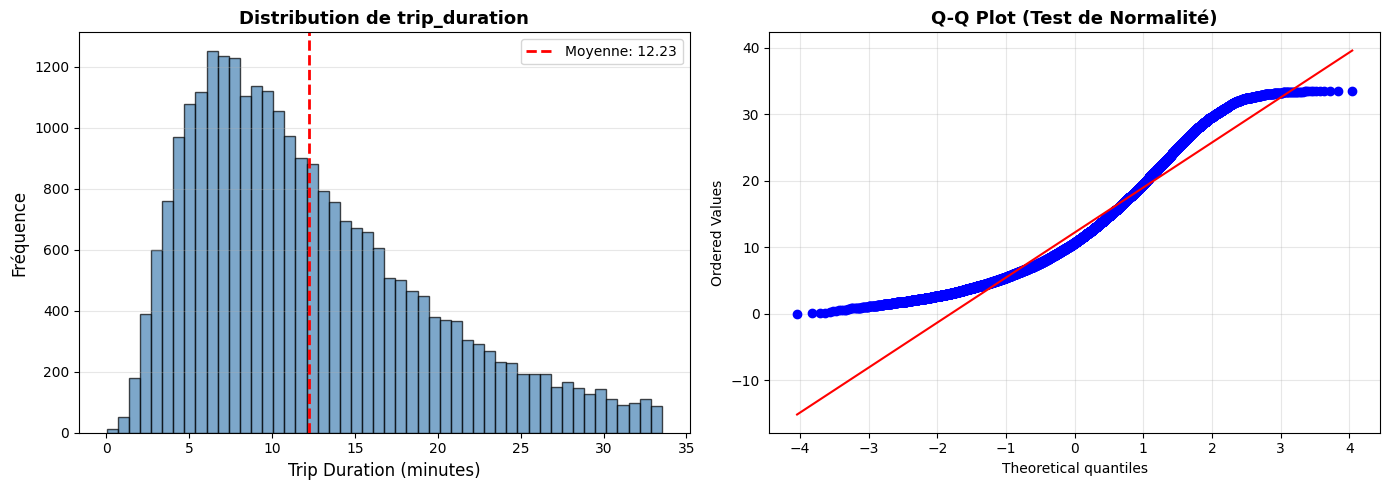

In [67]:
duration_sample = df_silver.select("trip_duration").sample(False, 0.01, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(duration_sample['trip_duration'], bins=50, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de trip_duration', fontsize=13, fontweight='bold')
axes[0].axvline(duration_sample['trip_duration'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Moyenne: {duration_sample["trip_duration"].mean():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

from scipy import stats
stats.probplot(duration_sample['trip_duration'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test de Normalité)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [68]:
nbr = df_silver.count()
print(nbr)

2607083


#### CRÉATION DE FEATURES TEMPORELLES

In [69]:
df_silver = df_silver \
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
    .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime"))) \
    .withColumn("month", month(col("tpep_pickup_datetime"))) 

#### VALIDATION DE LA COHÉRENCE

In [70]:
df_silver = df_silver.withColumn(
    "is_amount_consistent",
    when(
        abs(col("total_amount") - 
            (col("fare_amount") + col("extra") + col("mta_tax") + 
             col("tip_amount") + col("tolls_amount") + 
             col("improvement_surcharge") + col("congestion_surcharge") + 
             col("Airport_fee") + col("cbd_congestion_fee"))) < 0.5,
        True
    ).otherwise(False)
)

inconsistent_amounts = df_silver.filter(col("is_amount_consistent") == False).count()
print(f"✓ Montants incohérents détectés: {inconsistent_amounts:,}")

✓ Montants incohérents détectés: 552,065


In [71]:
nb_row_silver = df_silver.count()
print(nb_row_silver)
print(df_silver.columns)

2607083
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'outlier_type_iqr', 'pickup_hour', 'day_of_week', 'month', 'is_amount_consistent']


In [72]:
df_silver = df_silver.select(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'pickup_hour', 'day_of_week', 'month'])

### Visualisation

##### CALCUL DES CORRÉLATIONS AVEC trip_duration

In [73]:
numeric_features = [
    "trip_duration",
    "passenger_count",
    "trip_distance",
    "PULocationID",
    "DOLocationID",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee"
    ]

correlations = {}
for feature in numeric_features:
    corr = df_silver.stat.corr(feature, "trip_duration")
    correlations[feature] = corr
    

##### Trier par valeur absolue de corrélation

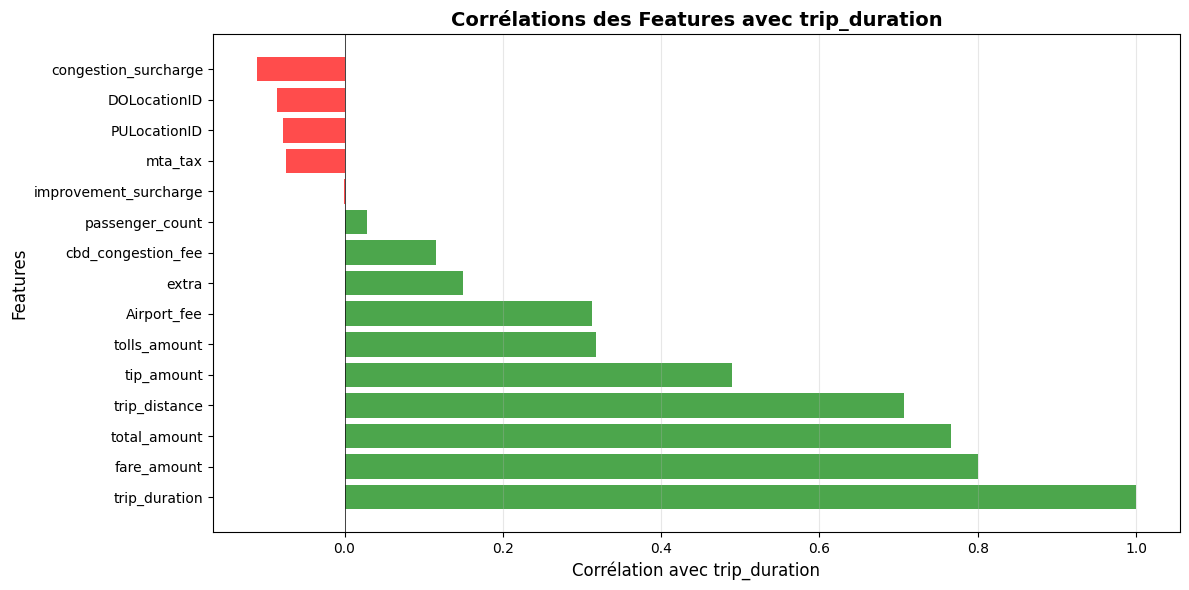

In [74]:
corr_df = pd.DataFrame(list(correlations.items()), 
                       columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=False)

# Graphique des corrélations
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in corr_df['Correlation']]
plt.barh(corr_df['Feature'], corr_df['Correlation'], color=colors, alpha=0.7)
plt.xlabel('Corrélation avec trip_duration', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Corrélations des Features avec trip_duration', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

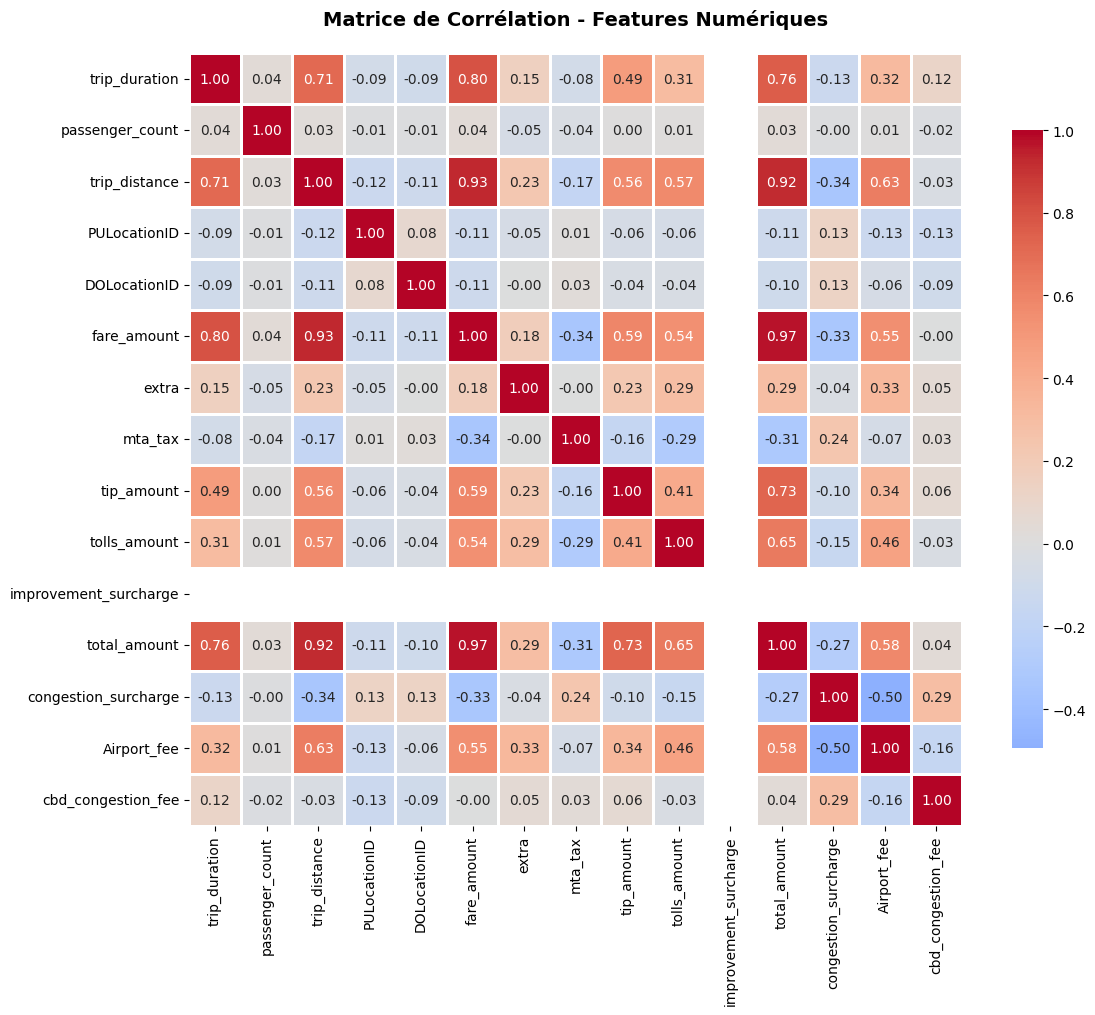

In [75]:

import seaborn as sns

# Échantillonner et convertir en pandas
df_corr = df_silver.select(numeric_features).sample(False, 0.01, seed=42).toPandas()

# Calculer la matrice de corrélation
corr_matrix = df_corr.corr()

# Visualiser
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Features Numériques', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### ANALYSE PAR VARIABLES CATÉGORIELLES

##### pickup_hour


⏰ ANALYSE PAR HEURE:


    pickup_hour  nb_trips  avg_duration  std_duration
0             0     61925     11.925009      7.106344
1             1     42380     11.504985      6.818075
2             2     28744     11.047568      6.534032
3             3     18537     11.017657      6.705221
4             4     11420     12.126951      7.752016
5             5     12813     11.449430      8.109650
6             6     29959     10.115032      6.717523
7             7     66513     10.873472      6.562621
8             8     97022     11.683847      6.771713
9             9    112609     12.190910      7.119459
10           10    123313     12.425270      7.215936
11           11    133860     12.599173      7.188200
12           12    144965     12.545754      7.168870
13           13    152301     12.768256      7.176997
14           14    161388     12.798565      7.195364
15           15    168626     12.607846      7.071264
16           16    170612     12.459416      7.046510
17           17    190715   

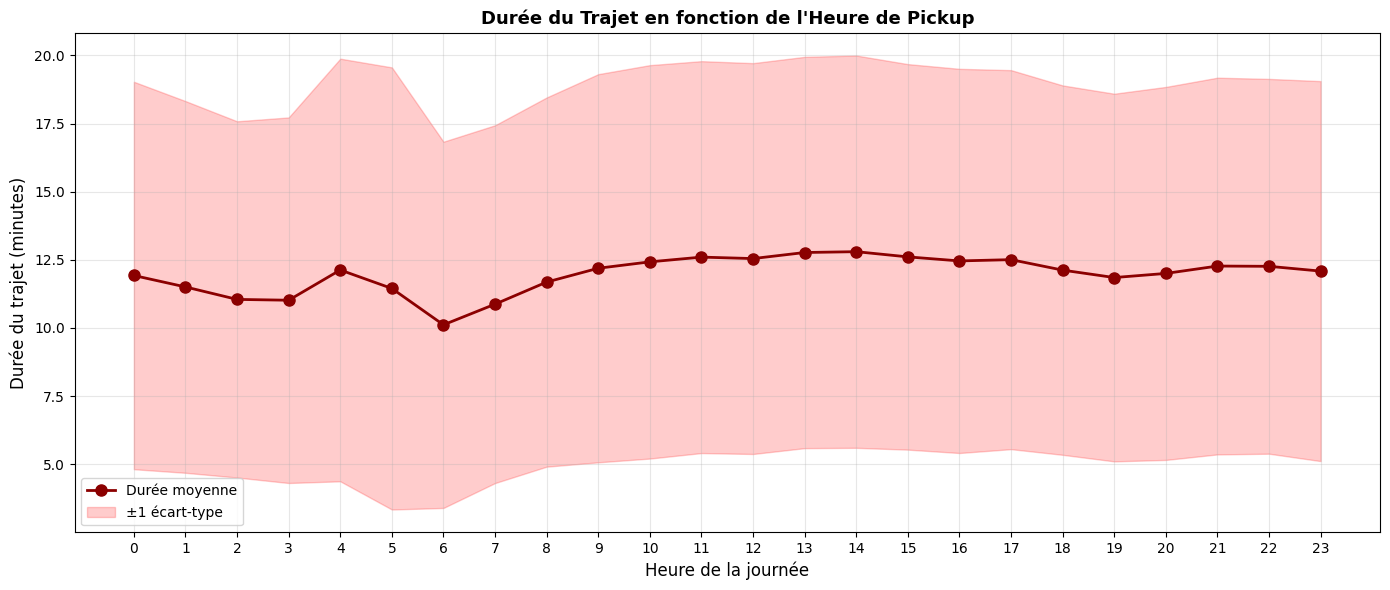

In [76]:
# --- pickup_hour ---
print("\n⏰ ANALYSE PAR HEURE:")
hourly_stats = df_silver.groupBy("pickup_hour").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("pickup_hour").toPandas()

print(hourly_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Durée moyenne par heure
ax.plot(hourly_stats['pickup_hour'], hourly_stats['avg_duration'], 
        marker='o', linewidth=2, markersize=8, color='darkred', label='Durée moyenne')
ax.fill_between(hourly_stats['pickup_hour'], 
                hourly_stats['avg_duration'] - hourly_stats['std_duration'],
                hourly_stats['avg_duration'] + hourly_stats['std_duration'],
                alpha=0.2, color='red', label='±1 écart-type')
ax.set_xlabel('Heure de la journée', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction de l\'Heure de Pickup', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(0, 24))
ax.legend()

plt.tight_layout()
plt.show()

#### day_of_week

   day_of_week  nb_trips  avg_duration  std_duration day_name
0            1    290828     11.582824      6.933765      Dim
1            2    277734     11.855297      6.968016      Lun
2            3    346528     12.236254      6.930981      Mar
3            4    433524     12.423292      7.047655      Mer
4            5    458573     12.643485      7.084478      Jeu
5            6    435408     12.380106      6.993388      Ven
6            7    364488     12.095455      6.962907      Sam


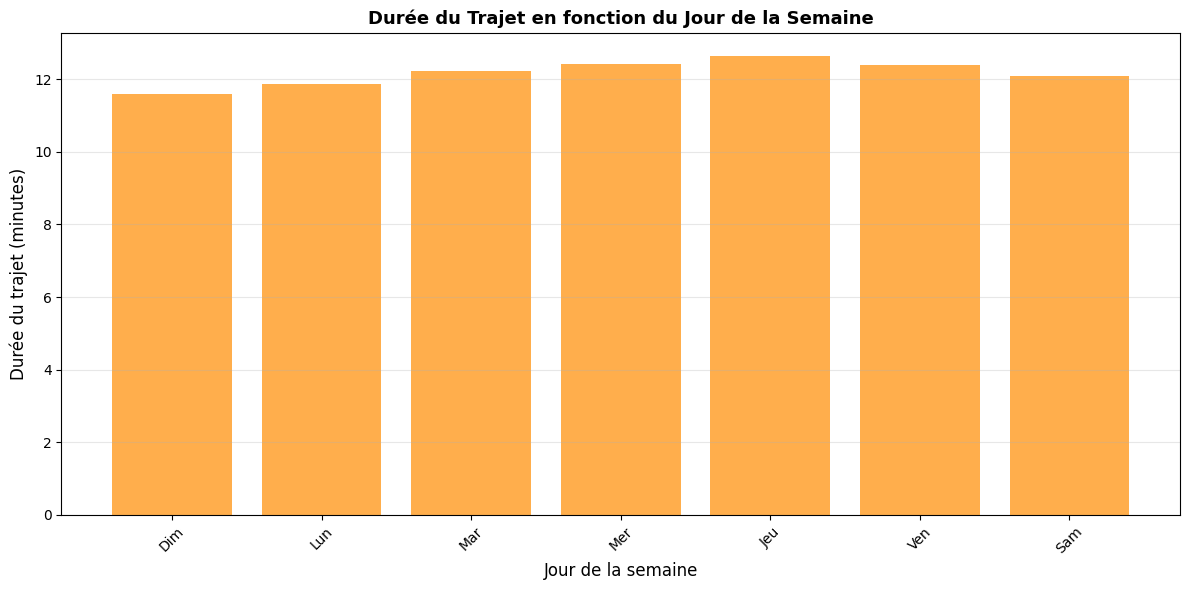

In [77]:
daily_stats = df_silver.groupBy("day_of_week").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("day_of_week").toPandas()

day_names = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']
daily_stats['day_name'] = daily_stats['day_of_week'].apply(lambda x: day_names[x-1])

print(daily_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Durée moyenne par jour
ax.bar(daily_stats['day_name'], daily_stats['avg_duration'], 
       color='darkorange', alpha=0.7)
ax.set_xlabel('Jour de la semaine', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Jour de la Semaine', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Month


⏰ ANALYSE PAR MONTH:


   month  nb_trips  avg_duration  std_duration
0      1   2607063     12.229858      7.004182
1      2         1      4.666667           NaN
2     12        19     11.642105      6.988709


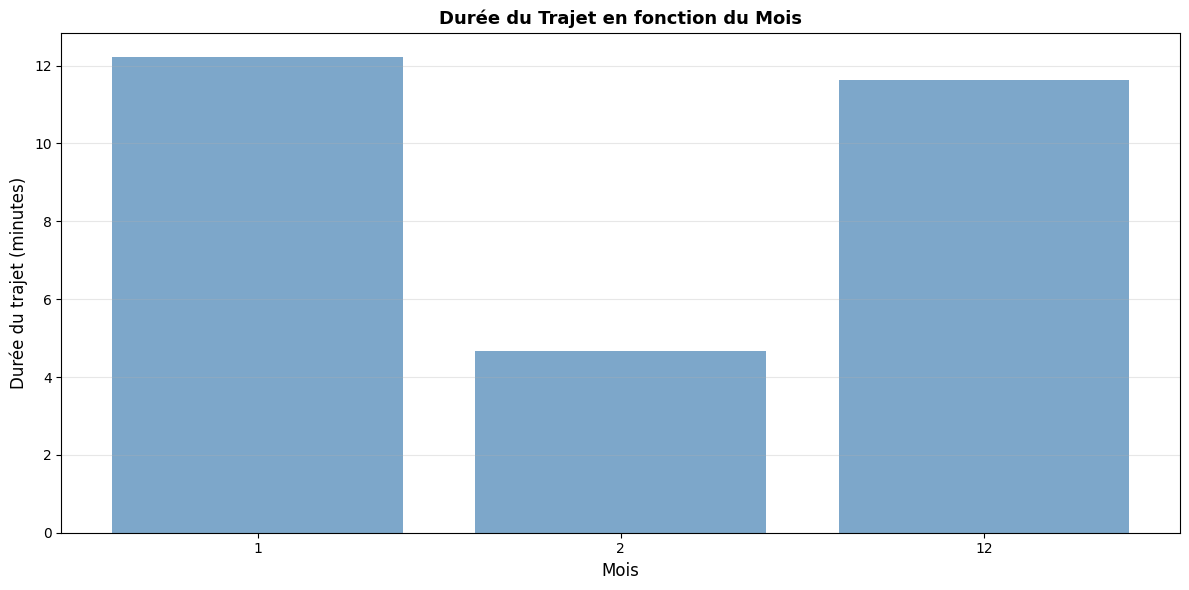

In [78]:
# --- Month ---
print("\n⏰ ANALYSE PAR MONTH:")
monthly_stats = df_silver.groupBy("month").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("month").toPandas()

print(monthly_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Durée moyenne par Mois
ax.bar(monthly_stats['month'].astype(str), monthly_stats['avg_duration'], 
       color='steelblue', alpha=0.7)
ax.set_xlabel('Mois', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Mois', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


🚕 ANALYSE PAR VENDORID:


   VendorID  nb_trips  avg_duration  std_duration
0         1    560348     12.265214      6.890026
1         2   2046735     12.220169      7.035081


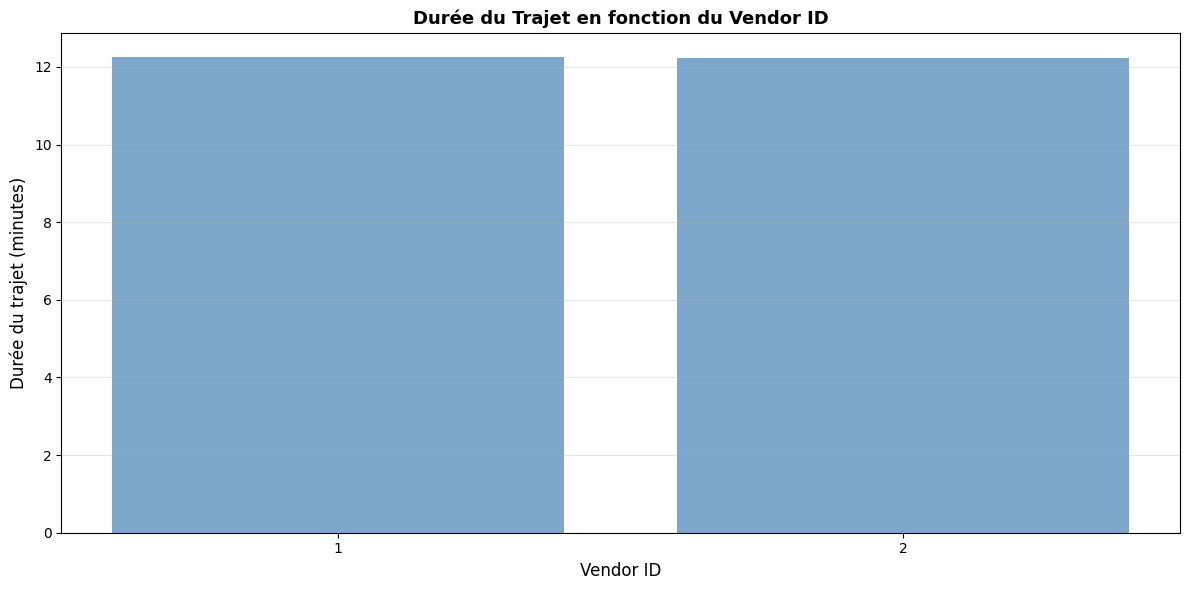


💵 ANALYSE PAR RATECODEID:


   RatecodeID  nb_trips  avg_duration  std_duration
0           1   2576580     12.091792      6.856942
1           2     15161     27.662006      6.915955
2           3      3731     25.049638      7.754539
3           4      3157     23.748337      5.948131
4           5      8447     16.685725      9.933918
5           6         7      0.733333      1.581607


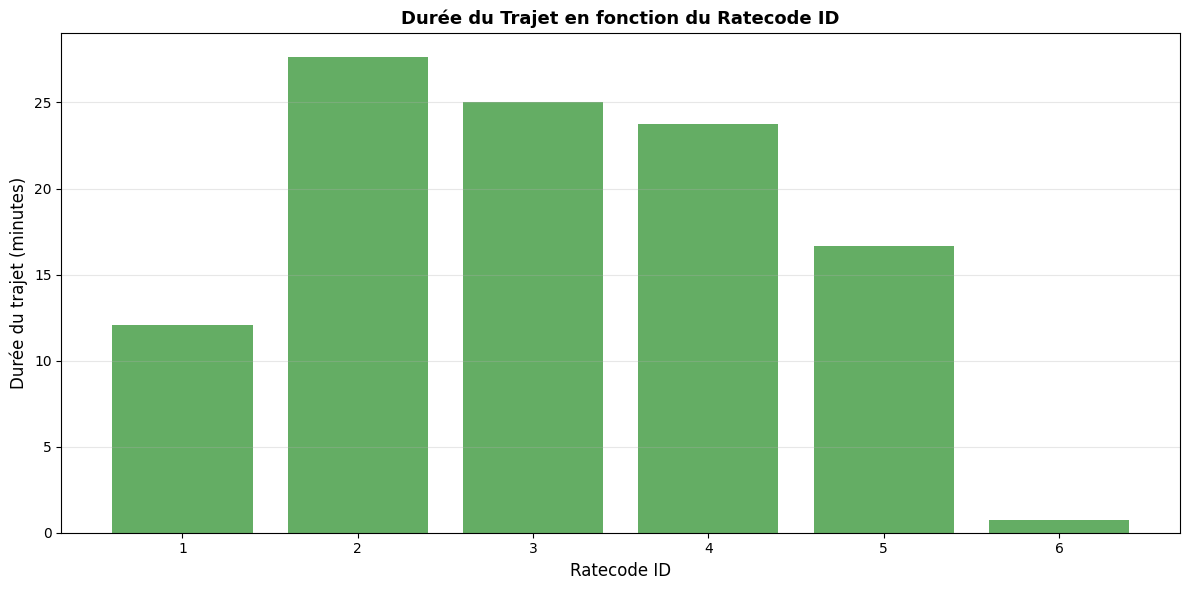


📦 ANALYSE PAR STORE_AND_FWD_FLAG:


  store_and_fwd_flag  nb_trips  avg_duration  std_duration
0                  N   2600589     12.229918      7.004477
1                  Y      6494     12.202828      6.885004


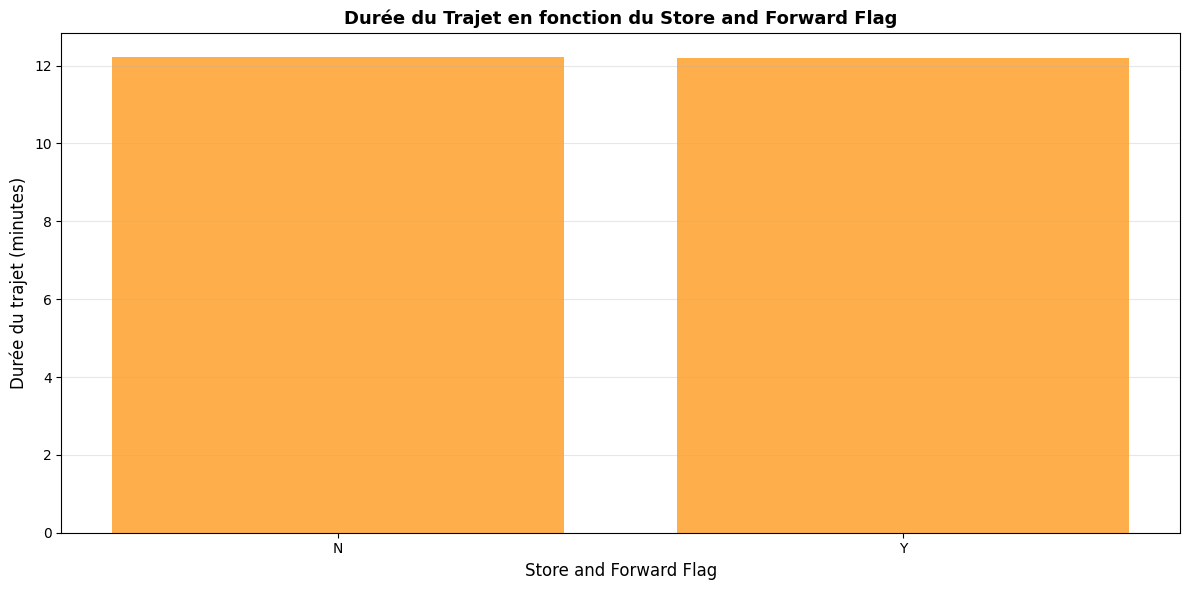


💳 ANALYSE PAR PAYMENT_TYPE:


   payment_type  nb_trips  avg_duration  std_duration
0             1   2228780     12.263421      6.981646
1             2    337173     12.057827      7.091046
2             3     10360     11.021559      7.380758
3             4     30770     12.090049      7.465548


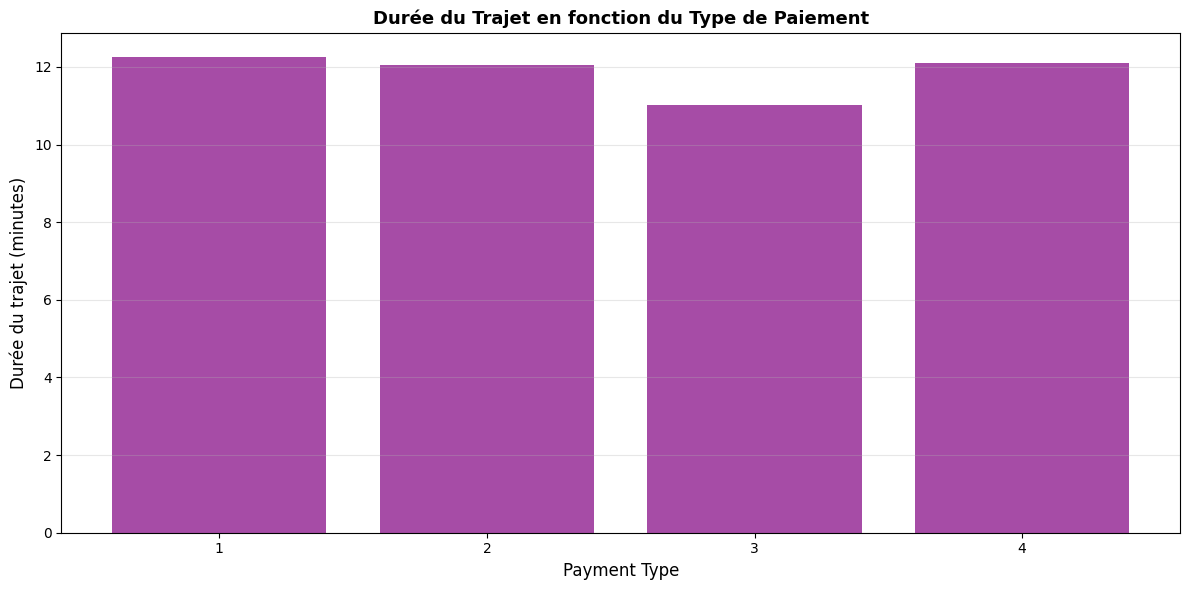

In [79]:
# --- vendorID ---
print("\n🚕 ANALYSE PAR VENDORID:")
vendor_stats = df_silver.groupBy("VendorID").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("VendorID").toPandas()

print(vendor_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(vendor_stats['VendorID'].astype(str), vendor_stats['avg_duration'], 
       color='steelblue', alpha=0.7)
ax.set_xlabel('Vendor ID', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Vendor ID', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- RatecodeID ---
print("\n💵 ANALYSE PAR RATECODEID:")
ratecode_stats = df_silver.groupBy("RatecodeID").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("RatecodeID").toPandas()

print(ratecode_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(ratecode_stats['RatecodeID'].astype(str), ratecode_stats['avg_duration'], 
       color='forestgreen', alpha=0.7)
ax.set_xlabel('Ratecode ID', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Ratecode ID', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- store_and_fwd_flag ---
print("\n📦 ANALYSE PAR STORE_AND_FWD_FLAG:")
store_stats = df_silver.groupBy("store_and_fwd_flag").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("store_and_fwd_flag").toPandas()

print(store_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(store_stats['store_and_fwd_flag'].astype(str), store_stats['avg_duration'], 
       color='darkorange', alpha=0.7)
ax.set_xlabel('Store and Forward Flag', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Store and Forward Flag', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- payment_type ---
print("\n💳 ANALYSE PAR PAYMENT_TYPE:")
payment_stats = df_silver.groupBy("payment_type").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("payment_type").toPandas()

print(payment_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(payment_stats['payment_type'].astype(str), payment_stats['avg_duration'], 
       color='purple', alpha=0.7)
ax.set_xlabel('Payment Type', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Type de Paiement', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [80]:
from pyspark.sql.functions import col, count

print("Distribution des valeurs de improvement_surcharge:")
df_silver.groupBy("improvement_surcharge").agg(
    count("*").alias("count")
).orderBy("improvement_surcharge").show()

Distribution des valeurs de improvement_surcharge:


+---------------------+-------+
|improvement_surcharge|  count|
+---------------------+-------+
|                  0.0|      4|
|                  1.0|2607079|
+---------------------+-------+



In [81]:
output_path = "../data/silver/trips_selected_parquet"

(
    df_silver
    .write
    .mode("overwrite")
    .parquet(output_path)
)


In [82]:
df_silver.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|     trip_duration|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+--